In [24]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [30]:
# HIDDEN
def total_variation_distance(column, other):
    return sum(np.abs(column - other)) / 2

def table_tvd(table, label, other):
    return total_variation_distance(table.column(label), table.column(other))

Our investigation of jury panels is an example of *hypothesis testing*. We wished to know the answer to a yes-or-no question about the world, and we reasoned about random samples in order to answer the question. In this section, we formalize the process.

## Sampling from a Distribution

The rows of a table describe individual elements of a collection of data. In the previous section, we worked with a table that described a distribution over categories. Tables that describe the proportions or counts of different categories in a sample or population arise often in data analysis as a summary of a data collection process. The `sample_from_distribution` method draws a sample of counts for the categories. Its implementation uses the same `np.random.multinomial` method from the previous section.

The table below describes the proportion of the eligible potential jurors in Alameda County (estimated from 2000 census data and other sources) for broad categories of race and ethnic background. This table was compiled by Professor Weeks, a demographer at San Diego State University, for the Alameda County trial *People v. Stuart Alexander* in 2002.

In [5]:
population = Table(["Race", "Eligible"]).with_rows([
    ["Asian",  0.15],
    ["Black",  0.18],
    ["Latino", 0.12],
    ["White",  0.54],
    ["Other",  0.01],
    ])
population

Race,Eligible
Asian,0.15
Black,0.18
Latino,0.12
White,0.54
Other,0.01


The `sample_from_distribution` method takes a number of samples and a column index or label. It returns a table in which the distribution column has been replaced by category counts of the sample. 

In [18]:
sample_size = 1453
population.sample_from_distribution("Eligible", sample_size)

Race,Eligible,Eligible sample
Asian,0.15,233
Black,0.18,245
Latino,0.12,177
White,0.54,787
Other,0.01,11


Each count is selected randomly in such a way that the chance of each category is the corresponding proportion in the original `"Eligible"` column. Sampling again will give different counts, but again the `"White"` category is much more common than `"Other"` because of its much higher proportion.

In [19]:
population.sample_from_distribution("Eligible", sample_size)

Race,Eligible,Eligible sample
Asian,0.15,227
Black,0.18,247
Latino,0.12,155
White,0.54,819
Other,0.01,5


The option `proportions=True` draws sample counts and then divides each count by the total number of samples. The result is another distribution; one based on a sample.

In [20]:
sample = population.sample_from_distribution("Eligible", sample_size, proportions=True)
sample

Race,Eligible,Eligible sample
Asian,0.15,0.140399
Black,0.18,0.189264
Latino,0.12,0.125258
White,0.54,0.532691
Other,0.01,0.0123882


This sample can itself be used to generate a sample. A sample of a sample is called a *resampled sample* or a *bootstrap sample*. It is not a random sample of the original distribution, but shares many characteristics with such a sample.

In [21]:
sample.sample_from_distribution('Eligible sample', sample_size)

Race,Eligible,Eligible sample,Eligible sample sample
Asian,0.15,0.140399,204
Black,0.18,0.189264,258
Latino,0.12,0.125258,163
White,0.54,0.532691,810
Other,0.01,0.0123882,18


## Empirical Distributions

An *empirical distribution* of a statistic is a table generated by computing the statistic for many samples. The previous section used empirical distributions to reason about whether or not a sample had a statistic that was typical of a random sample. The following function computes the empirical histogram of a statistic, which is expressed as a function that takes a sample.

In [46]:
def empirical_distribution(table, label, sample_size, k, f):
    stats = Table(['Sample #', 'Statistic'])
    for i in np.arange(k):
        sample = table.sample_from_distribution(label, sample_size)
        statistic = f(sample)
        stats.append([i, statistic])
    return stats

This function can be used to compute an empirical distribution of the total variation distance from the population distribution.

In [48]:
def tvd_from_eligible(sample):
    counts = sample.column('Eligible sample')
    distribution = counts / sum(counts)
    return total_variation_distance(population.column('Eligible'), distribution)

empirical_distribution(population, 'Eligible', sample_size, 1000, tvd_from_eligible)

Sample #,Statistic
0,0.0248796
1,0.0195664
2,0.00401927
3,0.0165864
4,0.0207502
5,0.013042
6,0.0297041
7,0.0153544
8,0.00830695
9,0.014384


The empirical distribution can be visualized using a histogram.

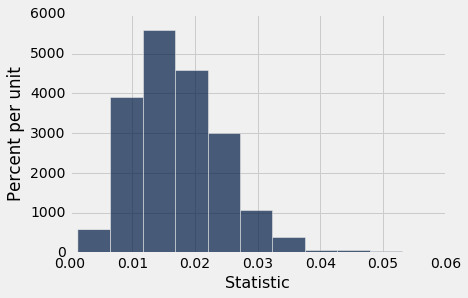

In [42]:
empirical_distribution(population, 'Eligible', sample_size, 1000, tvd_from_eligible).hist(1)

## U.S. Supreme Court, 1965: Swain vs. Alabama

In the early 1960's, in Talladega County in Alabama, a black man called Robert Swain was convicted of raping a white woman and was sentenced to death. He appealed his sentence, citing among other factors the all-white jury. At the time, only men aged 21 or older were allowed to serve on juries in Talladega County. In the county, 26% of the eligible jurors were black, but there were only 8 black men among the 100 selected for the jury panel in Swain's trial. No black man was selected for the trial jury.

In 1965, the Supreme Court of the United States denied Swain's appeal. In its ruling, the Court wrote "... the overall percentage disparity has been small and reflects no studied attempt to include or exclude a specified number of [black men]."

Let us use the methods we have developed to examine the disparity between 8 out of 100 and 26 out of 100 black men in a panel of 100 drawn at random from among the eligible jurors.

In [87]:
alabama = Table(['Race', 'Eligible']).with_rows([
    ["Black", 0.26],
    ["Other", 0.74]
])
alabama.set_format(1, PercentFormatter(0))

Race,Eligible
Black,26%
Other,74%


As our test statistic, we will use the number of black men in a random sample of size 100. Here is an empirical distribution of this statistic.

In [83]:
def value_for(category, category_label, value_label):
    def in_table(sample):
        return sample.where(category_label, category).column(value_label).item(0)
    return in_table

num_black = value_for('Black', 'Race', 'Eligible sample')

black_in_sample = empirical_distribution(alabama, 'Eligible', 100, 10000, num_black)
black_in_sample

Sample #,Statistic
0,27
1,31
2,28
3,27
4,24
5,23
6,29
7,28
8,16
9,25


The numbers of black men in the first 10 repetitions were quite a bit larger than 8. The empirical histogram below shows the distribution of the test statistic over all the repetitions. 

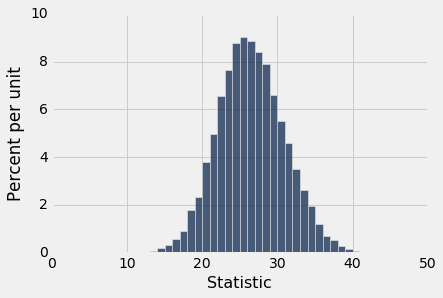

In [84]:
black_in_sample.hist(1, bins=np.arange(0, 50, 1))

If the 100 men in Swain's jury panel had been chosen at random, it would have been extremely unlikely for the number of black men on the panel to be as small as 8. We must conclude that the percentage disparity was larger than the disparity expected due to chance variation.

Method and Terminology of Statistical Tests of Hypotheses
-----------------------------------------------------

We have developed some of the fundamental concepts of statistical tests of hypotheses, in the context of examples about jury selection. Using statistical tests as a way of making decisions is standard in many fields and has a standard terminology. Here is the sequence of the steps in most statistical tests, along with some terminology and examples.

**STEP 1: THE HYPOTHESES**

All statistical tests attempt to choose between two views of how the data were generated. These two views are called *hypotheses*.

**The null hypothesis.** This says that the data were generated at random under clearly specified assumptions that make it possible to compute chances. The word "null" reinforces the idea that if the data look different from what the null hypothesis predicts, the difference is due to nothing but chance.

In both of our examples about jury selection, the null hypothesis is that the panels were selected at random from the population of eligible jurors. Though the racial composition of the panels was different from that of the populations of eligible jurors, there was no reason for the difference other than chance variation.

**The alternative hypothesis.** This says that some reason other than chance made the data differ from what was predicted by the null hypothesis. Informally, the alternative hypothesis says that the observed difference is "real."

In both of our examples about jury selection, the alternative hypothesis is that the panels were not selected at random. Something other than chance led to the differences between the racial composition of the panels and the racial composition of the populations of eligible jurors. 

**STEP 2: THE TEST STATISTIC**

In order to decide between the two hypothesis, we must choose a statistic upon which we will base our decision. This is called the **test statistic**.

In the example about jury panels in Alameda County, the test statistic we used was the total variation distance between the racial distributions in the panels and in the population of eligible jurors. In the example about Swain versus the State of Alabama, the test statistic was the number of black men on the jury panel.

Calculating the observed value of the test statistic is often the first computational step in a statistical test. In the case of jury panels in Alameda County, the observed value of the total variation distance between the distributions in the panels and the population was 0.14. In the example about Swain, the number of black men on his jury panel was 8.

**STEP 3: THE PROBABILITY DISTRIBUTION OF THE TEST STATISTIC, UNDER THE NULL HYPOTHESIS**

This step sets aside the observed value of the test statistic, and instead focuses on *what the value might be if the null hypothesis were true*. Under the null hypothesis, the sample could have come out differently due to chance. So the test statistic could have come out differently. This step consists of figuring out all possible values of the test statistic and all their probabilities, under the null hypothesis of randomness.

In other words, in this step we calculate the probability distribution of the test statistic pretending that the null hypothesis is true. For many test statistics, this can be a daunting task both mathematically and computationally. Therefore, we approximate the probability distribution of the test statistic by the empirical distribution of the statistic based on a large number of repetitions of the sampling procedure.

This was the empirical distribution of the test statistic – the number of black men on the jury panel – in the example about Swain and the Supreme Court:

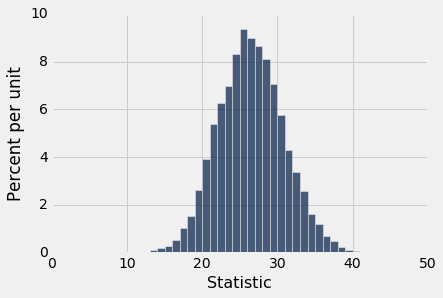

In [81]:
black_in_sample.hist(1, bins=np.arange(0, 50, 1))

**STEP 4. THE CONCLUSION OF THE TEST**

The choice between the null and alternative hypotheses depends on the comparison between the results of Steps 2 and 3: the observed test statistic and its distribution as predicted by the null hypothesis. 

If the two are consistent with each other, then the observed test statistic is in line with what the null hypothesis predicts. In other words, the test does not point towards the alternative hypothesis; the null hypothesis is better supported by the data.

But if the two are not consistent with each other, as is the case in both of our examples about jury panels, then the data do not support the null hypothesis. In both our examples we concluded that the jury panels were not selected at random. Something other than chance affected their composition.

**How is "consistent" defined?** Whether the observed test statistic is consistent with its predicted distribution under the null hypothesis is a matter of judgment. We recommend that you provide your judgment along with the value of the test statistic and a graph of its predicted distribution. That will allow your reader to make his or her own judgment about whether the two are consistent.

If you do not want to make your own judgment, there are conventions that you can follow. These conventions are based on what is called the **observed significance level** or *P-value* for short. The P-value is a chance computed using the probability distribution of the test statistic, and can be approximated by using the empirical distribution in Step 3. 

**Practical note on P-values and conventions.** Place the observed test statistic on the horizontal axis of the histogram, and find the proportion in the tail starting at that point. That's the P-value. 

If the P-value is small, the data support the alternative hypothesis. The conventions for what is "small":

- If the P-value is less than 5%, the result is called "statistically significant."

- If the P-value is even smaller – less than 1% – the result is called "highly statistically significant."

**More formal definition of P-value.** The P-value is the chance, under the null hypothesis, that the test statistic is equal to the value that was observed or is even further in the direction of the alternative.

The P-value is based on comparing the observed test statistic and what the null hypothesis predicts. A small P-value implies that under the null hypothesis, the value of the test statistic is unlikely to be near the one we observed. When a hypothesis and the data are not in accord, the hypothesis has to go. That is why we reject the null hypothesis if the P-value is small.

The P-value for the null hypothesis that Swain's jury panel was selected at random from the population of Talladega is approximated using the empirical distribution as follows:

In [86]:
np.count_nonzero(black_in_sample.column(1) <= 8) / black_in_sample.num_rows

0.0

**HISTORICAL NOTE ON THE CONVENTIONS**

The determination of statistical significance, as defined above, has become standard in statistical analyses in all fields of application. When a convention is so universally followed, it is interesting to examine how it arose. 

The method of statistical testing – choosing between hypotheses based on data in random samples – was developed by Sir Ronald Fisher in the early 20th century. Sir Ronald might have set the convention for statistical significance somewhat unwittingly, in the following statement in his 1925 book *Statistical Methods for Research Workers*. About the 5% level, he wrote, "It is convenient to take this point as a limit in judging whether a deviation is to be considered significant or not."

What was "convenient" for Sir Ronald became a cutoff that has acquired the status of a universal constant. No matter that Sir Ronald himself made the point that the value was his personal choice from among many: in an article in 1926, he wrote, "If one in twenty does not seem high enough odds, we may, if we prefer it draw the line at one in fifty (the 2 percent point), or one in a hundred (the 1 percent point). Personally, the author prefers to set a low standard of significance at the 5 percent point ..."

Fisher knew that "low" is a matter of judgment and has no unique definition. We suggest that you follow his excellent example. Provide your data, make your judgment, and explain why you made it.